For version 3, I use time_delay_embedding function, and time series split from James's LinearRegression_2.ipynb

In [23]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import re, math 
from scipy import stats
from tensorflow import keras
from sklearn.svm import SVR
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error as mse

In [24]:
# load the data that already clean
dataset = pd.read_csv('Covid_population_vaccine_fillna.csv', parse_dates=['date'])
dataset.tail()

,pruid,prname,date,reporting_year,numtotal_last7,ratecases_total,numdeaths,numdeaths_last7,ratedeaths,ratecases_last7,ratedeaths_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,totalcases,Population,Land_Area_Square_Kilometres,numtotal_atleast1dose,numtotal_partially,numtotal_fully
2320,60,Yukon,2023-01-14,2023,0,11393.27,32,0,73.08,0.00,0.00,0.00,0.00,0.00,4989,43241.0,472345.44,37130.0,1345.0,35785.0
2321,61,Northwest Territories,2023-01-14,2023,0,25240.65,22,0,48.24,0.00,0.00,0.00,0.00,0.00,11511,45710.0,1127711.92,35254.0,1454.0,33800.0
2322,62,Nunavut,2023-01-14,2023,0,8712.93,7,0,17.27,0.00,0.00,0.00,0.00,0.00,3531,40003.0,1836993.78,32797.0,2382.0,30415.0
2323,99,Repatriated travellers,2023-01-14,2023,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,13,0.0,0.00,0.0,0.0,0.0
2324,1,Canada,2023-01-14,2023,13948,11660.01,50135,222,128.78,35.83,0.57,5.12,31.65,0.08,4539229,38516138.0,8788702.80,32432766.0,2660851.0,24367850.0


In [25]:
def time_delay_embedding(series: pd.Series,
                         n_lags: int,
                         horizon: int,
                         return_Xy: bool = False):
    """
    Time delay embedding
    Time series for supervised learning
    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :param return_Xy: whether to return the lags split from future observations
    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    df_list = [series.shift(i) for i in n_lags_iter]
    df = pd.concat(df_list, axis=1).dropna()
    df.columns = [f'{name}(t-{j - 1})'
                  if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                  for j in n_lags_iter]

    df.columns = [re.sub('t-0', 't', x) for x in df.columns]

    if not return_Xy:
        return df

    is_future = df.columns.str.contains('\+')

    X = df.iloc[:, ~is_future]
    Y = df.iloc[:, is_future]
    if Y.shape[1] == 1:
        Y = Y.iloc[:, 0]

    return X, Y

In [26]:
# pruid is province id, and we use time series split, so we will drop them
dataset.drop(["pruid","reporting_year"], axis = 1, inplace = True) 
# dataset.drop(["pruid"], axis = 1, inplace = True)

In [27]:
# We focus on Ontario
data_ON=dataset[dataset.prname=="Ontario"].drop(["prname"], axis = 1) 
data_ON_2=dataset[dataset.prname=="Ontario"].drop(["prname"], axis = 1)
# setting date as index
data_ON.set_index('date', inplace=True)
data_ON_2.set_index('date', inplace=True)

In [28]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1)) 

for i in range(0,data_ON.shape[1]):
    # To scale data 
    scaler.fit(data_ON[data_ON.columns[i]].values.reshape(-1,1)) 
    data_ON[data_ON.columns[i]]=scaler.transform(data_ON[data_ON.columns[i]].values.reshape(-1,1))

# create data set with lagged features using time delay embedding
data_ON_ds = []
for col in data_ON:
    col_df = time_delay_embedding(data_ON[col], n_lags=24, horizon=0)
    data_ON_ds.append(col_df)

# concatenating all variables
data_ON_df = pd.concat(data_ON_ds, axis=1).dropna()

# defining target (Y) and explanatory variables (X)
predictor_variables = data_ON_df.columns.str.contains('\(t\-')
target_variables = data_ON_df.columns.str.contains('totalcases\(t\)')

X = data_ON_df.iloc[:, predictor_variables]
Y = data_ON_df.iloc[:, target_variables]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=24, shuffle=False)

In [29]:
# Train and evaluate the model
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scaler.fit(data_ON_2["totalcases"].values.reshape(-1,1))
    rmse = math.sqrt(mse(y_test, preds))
    mae_value = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return preds, rmse, mae_value, r2

# Create a simple LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train and evaluate the LSTM model
def train_and_evaluate_lstm_model(X_train, X_test, y_train, y_test):
    X_train = X_train.to_numpy().reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.to_numpy().reshape(X_test.shape[0], 1, X_test.shape[1])
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=100, verbose=0)
    preds = model.predict(X_test)
    rmse = math.sqrt(mse(y_test, preds))
    mae_value = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return preds, rmse, mae_value, r2

# Train and evaluate the ARIMA model
def train_and_evaluate_arima_model(y_train, y_test, order):
    model = ARIMA(y_train, order=order)
    model_fit = model.fit()
    # preds = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
    preds = model_fit.forecast(steps=len(y_test))
    rmse = math.sqrt(mse(y_test, preds))
    mae_value = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return preds, rmse, mae_value, r2

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=24, shuffle=False)

# Prepare models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Trees": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor()
}

# Train, evaluates, and plots the models:
# Initialize the results dictionary
results = {}

# Train, evaluate and plot for each model
for name, model in models.items():
    preds, rmse, mae, r2 = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {"Predictions": preds, "RMSE": rmse, "MAE": mae, "R2": r2}

# Train, evaluate and plot for LSTM model
lstm_preds, lstm_rmse, lstm_mae, lstm_r2 = train_and_evaluate_lstm_model(X_train, X_test, y_train, y_test)
results["LSTM"] = {"Predictions": lstm_preds, "RMSE": lstm_rmse, "MAE": lstm_mae, "R2": lstm_r2}

# Train, evaluate and plot for ARIMA model
arima_preds, arima_rmse, arima_mae, arima_r2 = train_and_evaluate_arima_model(y_train.squeeze(), y_test.squeeze(), (3, 1, 0))
results["ARIMA"] = {"Predictions": arima_preds, "RMSE": arima_rmse, "MAE": arima_mae, "R2": arima_r2}

# Reverse the scaling for all predictions
for name in results.keys():
    preds = np.array(results[name]["Predictions"])
    inv_y = scaler.inverse_transform(preds.reshape(-1, 1))
    results[name]["Predictions"] = inv_y[:, 0]



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/s1/4fm2_tw16qzdhqgqcb0ry6rm0000gn/T/ipykernel_8613/2408417894.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


1/1 [==============================] - 0s 115ms/step


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


/var/folders/s1/4fm2_tw16qzdhqgqcb0ry6rm0000gn/T/ipykernel_8613/279802268.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


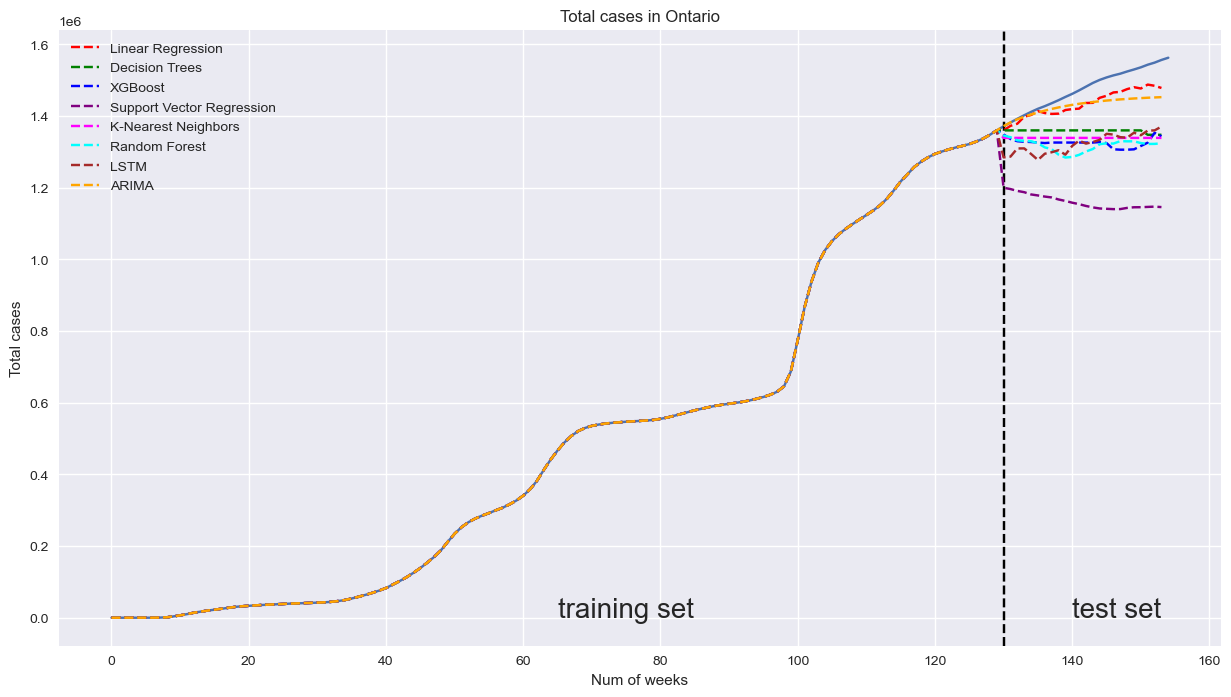

Linear Regression:
RMSE: 0.027944884703822778
MAE: 0.024705227152043138
R2 Score: 0.39105409978949746

Decision Trees:
RMSE: 0.08164171030865162
MAE: 0.0726528923328278
R2 Score: -4.19754496211465

XGBoost:
RMSE: 0.10118544964274193
MAE: 0.09351037067197591
R2 Score: -6.983810100842263

Support Vector Regression:
RMSE: 0.20478830456656094
MAE: 0.19917654861748013
R2 Score: -31.702757025282764

K-Nearest Neighbors:
RMSE: 0.0923216575867684
MAE: 0.08509336814242723
R2 Score: -5.646320092715491

Random Forest:
RMSE: 0.10557204292384931
MAE: 0.09838642893249999
R2 Score: -7.691043386490339

LSTM:
RMSE: 0.09755385546546791
MAE: 0.09526969116948873
R2 Score: -6.421008732441381

ARIMA:
RMSE: 0.035739849339401185
MAE: 0.028408428470206238
R2 Score: 0.003953757519322254



In [30]:
# Set style
plt.style.use('seaborn')

# Define colors for each model
colors = {
    "Linear Regression": "red",
    "Decision Trees": "green",
    "XGBoost": "blue",
    "Support Vector Regression": "purple",
    "K-Nearest Neighbors": "magenta",
    "Random Forest": "cyan",
    "LSTM": "brown",
    "ARIMA": "orange"
}

# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(data_ON_2["totalcases"].values)
plt.axvline(130, color="black", ls='--')
plt.title("Total cases in Ontario")
plt.xlabel('Num of weeks')
plt.ylabel('Total cases')
plt.text(65, 20, 'training set', fontsize=20)
plt.text(140, 20, 'test set', fontsize=20)

for name in results.keys(): 
    cb = np.hstack((data_ON_2["totalcases"][0:130].values, results[name]["Predictions"]))
    plt.plot(cb, color=colors[name], linestyle="--", label=name)

plt.legend(loc='upper left')
plt.show()

# Output the results
for name in results.keys():
    print(f"{name}:")
    print("RMSE:", results[name]["RMSE"])
    print("MAE:", results[name]["MAE"])
    print("R2 Score:", results[name]["R2"])
    print("")

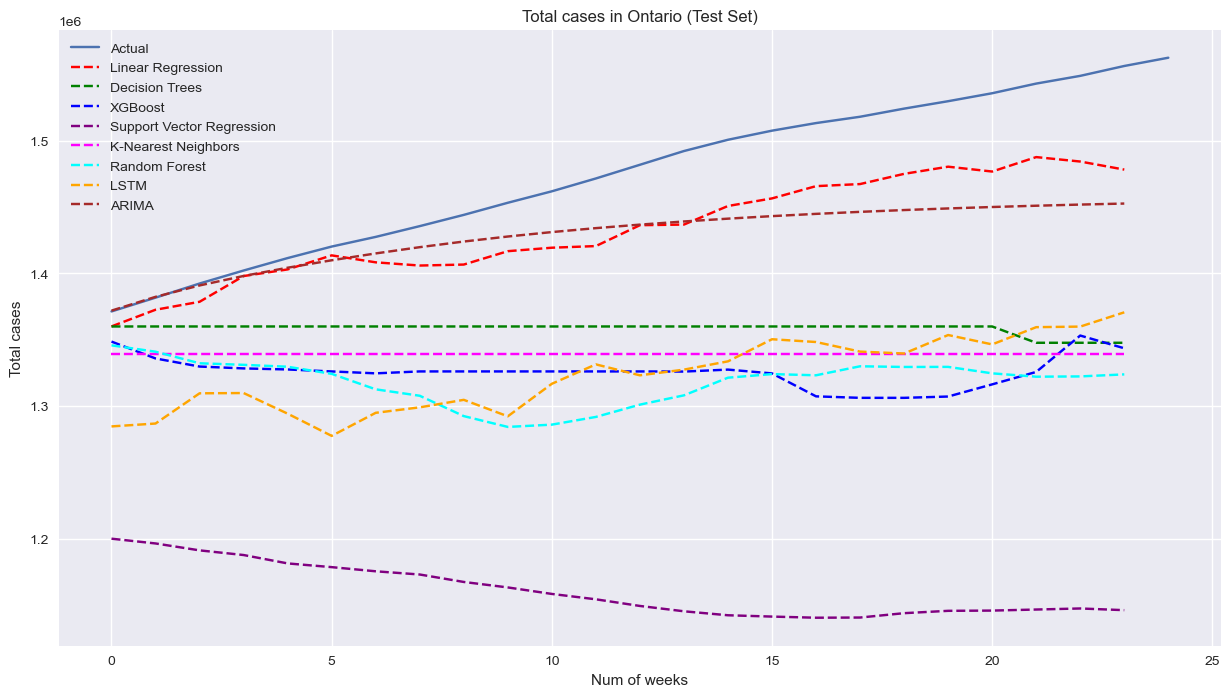

In [31]:
# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(data_ON_2["totalcases"][130:].values)
plt.title("Total cases in Ontario (Test Set)")
plt.xlabel('Num of weeks')
plt.ylabel('Total cases')

colors = iter(["red", "green", "blue", "purple", "magenta", "cyan", "orange", "brown"])
for name in results.keys():
    plt.plot(results[name]["Predictions"], color=next(colors), linestyle="--")
    plt.legend(["Actual"] + list(results.keys()), loc='upper left')
plt.show()

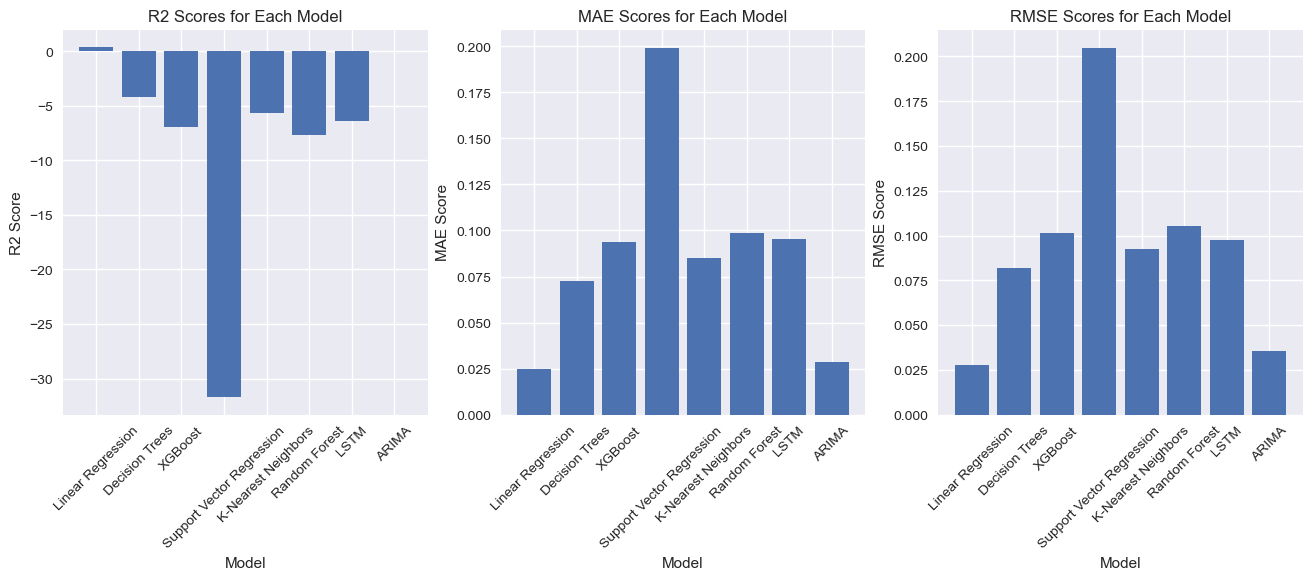

In [32]:
# Extract R2 and RMSE for each model
model_names = list(results.keys())
r2_scores = [results[name]["R2"] for name in model_names]
rmse_scores = [results[name]["RMSE"] for name in model_names]
mae_scores = [results[name]["MAE"] for name in model_names]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot R2 scores
axes[0].bar(model_names, r2_scores)
axes[0].set_title("R2 Scores for Each Model")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("R2 Score")
axes[0].tick_params(axis='x', rotation=45)

# Plot MAE scores
axes[1].bar(model_names, mae_scores)
axes[1].set_title("MAE Scores for Each Model")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("MAE Score")
axes[1].tick_params(axis='x', rotation=45)

# Plot RMSE scores
axes[2].bar(model_names, rmse_scores)
axes[2].set_title("RMSE Scores for Each Model")
axes[2].set_xlabel("Model")
axes[2].set_ylabel("RMSE Score")
axes[2].tick_params(axis='x', rotation=45)

plt.show()

In [33]:
# Find the best model based on RMSE, MAE, and R2
best_rmse_model = min(results.items(), key=lambda x: x[1]["RMSE"])[0]
best_mae_model = min(results.items(), key=lambda x: x[1]["MAE"])[0]
best_r2_model = max(results.items(), key=lambda x: x[1]["R2"])[0]

print(f"Best model based on RMSE: {best_rmse_model}")
print(f"Best model based on MAE: {best_mae_model}")
print(f"Best model based on R2: {best_r2_model}")

# Summarize the findings
best_model = max(results, key=lambda x: results[x]['R2'])
print("The best model is:", best_model)
print("Evaluation metrics for the best model are:")
print("RMSE:", results[best_model]['RMSE'])
print("MAE:", results[best_model]['MAE'])
print("R2:", results[best_model]['R2'])

Best model based on RMSE: Linear Regression
Best model based on MAE: Linear Regression
Best model based on R2: Linear Regression
The best model is: Linear Regression
Evaluation metrics for the best model are:
RMSE: 0.027944884703822778
MAE: 0.024705227152043138
R2: 0.39105409978949746
